In [4]:
import matplotlib.pyplot as plt
import sys, os
sys.path.append('..')
import json
from ml_collections import ConfigDict

import torch
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader as pygdl
import torchmetrics.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dataloader import DreamLoader
from dataloader.representations.graph_utils import from_smiles, NODE_DIM, EDGE_DIM
from pom.gnn.graphnets import GraphNets
from chemix.data import get_mixture_smiles
from chemix import Chemix, MixtureNet, Regressor
from chemix.model import AttentionAggregation

import torchinfo

# End-to-end CheMix model

In [5]:
fname = f'scripts_chemix/chemix_end2end/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Running on: {device}')

Running on: cpu


## Load Data (Competition Dataset, Extra Dataset, and Leaderboard Dataset)

In [6]:
# training set
dl = DreamLoader()
dl.load_benchmark('competition_train')
dl.featurize('competition_smiles')
graph_list, train_indices = get_mixture_smiles(dl.features, from_smiles)
train_gr = Batch.from_data_list(graph_list)
y_train = torch.tensor(dl.labels, dtype=torch.float32).to(device)

# extra set
dl_extra = DreamLoader()
dl_extra.load_benchmark('competition_extra')
dl_extra.featurize('competition_smiles')
graph_list, extra_indices = get_mixture_smiles(dl_extra.features, from_smiles)
extra_gr = Batch.from_data_list(graph_list)
y_extra = torch.tensor(dl_extra.labels, dtype=torch.float32).to(device)

# testing set
dl_test = DreamLoader()
dl_test.load_benchmark('competition_leaderboard')
dl_test.featurize('competition_smiles')
graph_list, test_indices = get_mixture_smiles(dl_test.features, from_smiles)
test_gr = Batch.from_data_list(graph_list)
y_test = torch.tensor(dl_test.labels, dtype=torch.float32).to(device)

competition_train dataset is known to have invalid entries. Validation is turned off.
competition_extra dataset is known to have invalid entries. Validation is turned off.
competition_leaderboard dataset is known to have invalid entries. Validation is turned off.


## Load POM and CheMix fine-tuned model with optimized hyperparameters

In [9]:
# using optimized hyperparameters
hp_gnn = ConfigDict(json.load(open(f'{fname}/hparams_graphnets.json', 'r')))
hp_mix = ConfigDict(json.load(open(f'{fname}/hparams_chemix.json', 'r')))

# create the pom embedder model
embedder = GraphNets(node_dim=NODE_DIM, edge_dim=EDGE_DIM, **hp_gnn)
embedder.load_state_dict(torch.load(f'{fname}/gnn_embedder.pt', map_location=device))
embedder = embedder.to(device)


# create the chemix model
mixture_net = MixtureNet(
    num_layers=hp_mix.num_layers,
    embed_dim=hp_mix.embed_dim,
    num_heads=1,
    mol_aggregation=AttentionAggregation(hp_mix.embed_dim),
    dropout_rate=hp_mix.dropout,
)

regressor = Regressor(
    hidden_dim=2*hp_mix.embed_dim,   # multiply by 4 for pna
    output_dim=1,
    num_layers=hp_mix.num_layers,
    dropout_rate=hp_mix.dropout,
)

chemix = Chemix(
    input_net=None,
    regressor=regressor,
    mixture_net=mixture_net,
    unk_token=hp_mix.unk_token,
).to(device)

torchinfo.summary(chemix)
chemix.load_state_dict(torch.load(f'{fname}/chemix.pt', map_location=device))
chemix = chemix.to(device)

## Inference on the out-of-distribution dataset

In [10]:
### CHECK PERFORMANCE ON THE EXTRA DATA SET 
# save the results in a file
embedder.eval(); chemix.eval()
with torch.no_grad():
    out = embedder.graphs_to_mixtures(extra_gr, extra_indices, device=device)
    y_pred = chemix(out)

# calculate the metrics
rho = F.pearson_corrcoef(y_pred.flatten(), y_extra.flatten())
y_pred = y_pred.detach().cpu().numpy().flatten()
y_extra = y_extra.detach().cpu().numpy().flatten()
leaderboard_predictions = pd.DataFrame({
    'Predicted_Experimental_Values': y_pred, 
    'Ground_Truth': y_extra,
    'MAE': np.abs(y_pred - y_extra),
}, index=range(len(y_pred)))
leaderboard_predictions.to_csv(f'{fname}/extra_predictions.csv')

## Plot predictions vs ground_truth

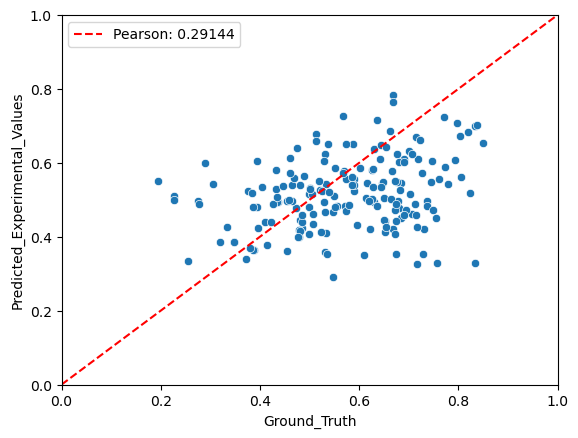

In [12]:
# plot the predictions
sns.scatterplot(data=leaderboard_predictions, x='Ground_Truth', y='Predicted_Experimental_Values')
plt.plot([0,1], [0,1], 'r--', label=f'Pearson: {rho:.5f}')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.show()

## Inference on the leaderboard dataset

In [13]:
### CHECK PERFORMANCE ON THE LEADERBOARD SET
# This is a reload run, just to sanity check
embedder.eval(); chemix.eval()
with torch.no_grad():
    out = embedder.graphs_to_mixtures(test_gr, test_indices, device=device)
    y_pred = chemix(out)

# calculate the metrics
rho = F.pearson_corrcoef(y_pred.flatten(), y_test.flatten())
y_pred = y_pred.detach().cpu().numpy().flatten()
y_test = y_test.detach().cpu().numpy().flatten()
leaderboard_predictions = pd.DataFrame({
    'Predicted_Experimental_Values': y_pred, 
    'Ground_Truth': y_test,
    'MAE': np.abs(y_pred - y_test),
}, index=range(len(y_pred)))
leaderboard_predictions.to_csv(f'{fname}/leaderboard_predictions.csv')

## Plot predictions vs. ground_truth

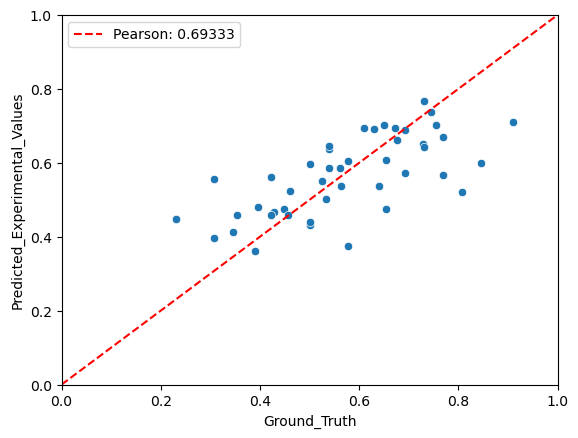

In [14]:
sns.scatterplot(data=leaderboard_predictions, x='Ground_Truth', y='Predicted_Experimental_Values')
plt.plot([0,1], [0,1], 'r--', label=f'Pearson: {rho:.5f}')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.show()